# Food Cost Prediction Model Experiments

#### Experiments by Grace Ivey and Sydney Balboni

## Imports

In [20]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## Data Visualization

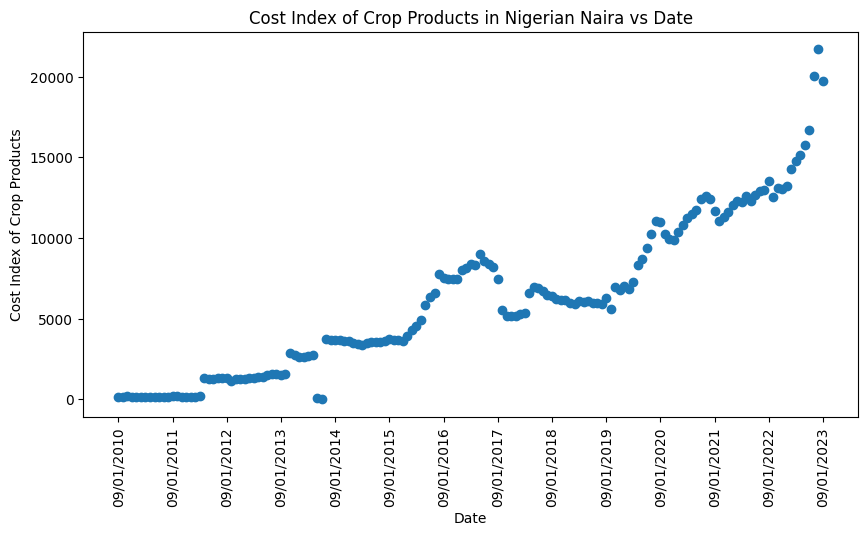

In [21]:
# Load cleaned data
df = pd.read_csv('cleaned_cost_index_of_crop_products_nigerian_naira.csv')

# Vizualize the data
plt.figure(figsize=(10, 5))
plt.title('Cost Index of Crop Products in Nigerian Naira vs Date')
plt.scatter(df['Date'], df['Cost Index of Crop Products in Nigerian Naira'])
plt.xlabel('Date')
plt.xticks(df['Date'][::12], rotation=90)
plt.xticks(rotation=90)
plt.ylabel('Cost Index of Crop Products')
plt.show()

## Linear Regression
#### Data Loading for Linear Regression

In [22]:
# Shuffle the DataFrame
# df_shuffled = df.sample(frac=1).reset_index(drop=True)

# Split data into features (X) and target (y)
# X is the list of indices of the crop products
X = df.index.tolist()
y = df['Cost Index of Crop Products in Nigerian Naira'].values

# Split the dataset into training and test sets
# 80% of the data will be used for training and 20% for testing
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
x_train = np.array(x_train).reshape(-1, 1)
x_test = np.array(x_test).reshape(-1, 1)


#### Run the Linear Regression Model

In [23]:
# Run the model
lin_model = LinearRegression()
lin_model.fit(x_train, y_train)
y_predict = lin_model.predict(x_test)

# Calculate Mean Squared Error
mse_lin_reg = mean_squared_error(y_test, y_predict)
print(f"Mean Squared Error: {mse_lin_reg}")

# Calculate Mean Absolute Error
mae_lin_reg = mean_absolute_error(y_test, y_predict)
print(f"Mean Absolute Error: {mae_lin_reg}")

# Calculate R-squared
r_squared_lin_reg = r2_score(y_test, y_predict)
print(f"R-squared: {r_squared_lin_reg}")

Mean Squared Error: 3543976.8358316636
Mean Absolute Error: 1145.89095754008
R-squared: 0.870835295514963


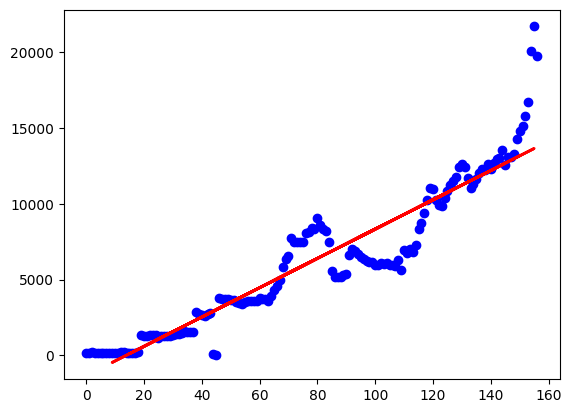

In [24]:
# Plot the regression line and data
plt.scatter(X, y, color='blue')
plt.plot(x_test, y_predict, color='red', linewidth=2)
plt.show()


## Transformer
#### Data Loading for Transformer

In [25]:
data = df['Cost Index of Crop Products in Nigerian Naira'].values
data

array([  170.    ,   171.    ,   195.    ,   126.    ,   124.    ,
         129.    ,   143.    ,   161.    ,   166.    ,   179.    ,
         160.    ,   166.    ,   222.    ,   217.    ,   157.    ,
         175.    ,   160.    ,   183.    ,   196.    ,  1350.9987,
        1280.9987,  1262.375 ,  1318.2   ,  1354.    ,  1315.8334,
        1150.3335,  1255.75  ,  1271.2   ,  1265.875 ,  1300.125 ,
        1348.6   ,  1398.75  ,  1419.75  ,  1494.7   ,  1582.375 ,
        1572.25  ,  1533.4   ,  1549.125 ,  2879.925 ,  2743.25  ,
        2635.    ,  2605.5   ,  2708.6   ,  2765.6668,    68.    ,
           0.    ,  3754.2   ,  3701.84  ,  3698.    ,  3707.2001,
        3628.966 ,  3622.96  ,  3507.45  ,  3420.65  ,  3382.76  ,
        3488.89  ,  3583.12  ,  3579.4025,  3562.06  ,  3609.384 ,
        3757.03  ,  3711.4   ,  3697.16  ,  3616.85  ,  3912.96  ,
        4299.8   ,  4572.255 ,  4950.925 ,  5837.52  ,  6371.2   ,
        6576.784 ,  7753.14  ,  7502.95  ,  7452.52  ,  7488.3

In [26]:
# Make sequence for transformer to learn from
sequence_length = 3
sequences = [] # Sequence of data points
next_values = [] # The following value beyond the sequence of data points

for i in range(sequence_length, len(data)): 
    sequences.append(data[i - sequence_length:i])  
    next_values.append(data[i]) 

In [27]:
x_train, x_test, y_train, y_test = train_test_split(
    sequences, next_values, test_size=0.2, shuffle=False
)
y_train

[126.0,
 124.0,
 129.0,
 143.0,
 161.0,
 166.0,
 179.0,
 160.0,
 166.0,
 222.0,
 217.0,
 157.0,
 175.0,
 160.0,
 183.0,
 196.0,
 1350.9987,
 1280.9987,
 1262.375,
 1318.2,
 1354.0,
 1315.8334,
 1150.3335,
 1255.75,
 1271.2,
 1265.875,
 1300.125,
 1348.6,
 1398.75,
 1419.75,
 1494.6999999999998,
 1582.375,
 1572.25,
 1533.4,
 1549.125,
 2879.925,
 2743.25,
 2635.0,
 2605.5,
 2708.6,
 2765.6668,
 68.0,
 0.0,
 3754.2,
 3701.84,
 3698.0,
 3707.2001,
 3628.966,
 3622.96,
 3507.45,
 3420.65,
 3382.76,
 3488.89,
 3583.12,
 3579.4025,
 3562.06,
 3609.384,
 3757.03,
 3711.4,
 3697.16,
 3616.85,
 3912.96,
 4299.8,
 4572.254999999999,
 4950.924999999999,
 5837.52,
 6371.2,
 6576.784,
 7753.139999999999,
 7502.95,
 7452.52,
 7488.3,
 7469.049999999999,
 8037.68,
 8149.35,
 8365.75,
 8347.08,
 9038.45,
 8567.35,
 8362.92,
 8216.55,
 7486.8835,
 5535.96,
 5196.6,
 5145.72,
 5191.200000000001,
 5303.349999999999,
 5386.099999999999,
 6622.88,
 6981.966700000001,
 6880.5317000000005,
 6712.906,
 6496.

In [28]:
# Scaler for scaling the data
scaler = StandardScaler()

# Scale the x_train and x_test
x_train_scaled = scaler.fit_transform(np.array(x_train).reshape(-1, sequence_length)).reshape(-1, sequence_length, 1)
x_test_scaled = scaler.transform(np.array(x_test).reshape(-1, sequence_length)).reshape(-1, sequence_length, 1)

# Scale the y_train and y_test 
y_train_scaled = scaler.fit_transform(np.array(y_train).reshape(-1, 1))
y_test_scaled = scaler.transform(np.array(y_test).reshape(-1, 1))

In [29]:
# Form tensors from the data
# Data needs to be in tensors for the model to ingest
x_train_tensor = tf.convert_to_tensor(x_train_scaled, dtype=tf.float32)
x_test_tensor = tf.convert_to_tensor(x_test_scaled, dtype=tf.float32)
y_train_tensor = tf.convert_to_tensor(y_train_scaled, dtype=tf.float32)
y_test_tensor = tf.convert_to_tensor(y_test_scaled, dtype=tf.float32)

#### Model Definition

In [30]:
# Transformer Model 
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = tf.keras.layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = tf.keras.layers.Dropout(dropout)(x)
    res = x + inputs
    x = tf.keras.layers.LayerNormalization(epsilon=1e-6)(res)
    x = tf.keras.layers.Conv1D(filters=ff_dim, kernel_size=1, activation='relu')(x)
    x = tf.keras.layers.Dropout(dropout)(x)
    x = tf.keras.layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res  

#### Model Implementation

In [31]:
# Define positional encoding function
def positional_encoding(length, depth):
    """ 
    Create positional encoding
    args:
        length: length of the sequence
        depth: depth of the model
    """
    pos_enc = np.array([
        [pos / np.power(10000, 2 * (j // 2) / depth) for j in range(depth)]
        for pos in range(length)
    ])
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])
    return tf.cast(pos_enc, dtype=tf.float32)

In [32]:
# Model parameters
head_size = 64
num_epochs = 200
batch_size = 32
num_heads = 16
ff_dim = 16

d_model = x_train_tensor.shape[-1] 
length = x_train_tensor.shape[1]  

# Define the input layer
inputs = tf.keras.Input(shape=(sequence_length, d_model))

# Add positional encoding to the input
# The positional encoding is added to the input in order to give the model some information about the relative position of the words in the sequence
# Not including the positional encoding is basically the same as randomizing the order of the data
x = inputs + positional_encoding(sequence_length, d_model) 

# Transformer Encoder
x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim)

# Global Average Pooling layer
# The Global Average Pooling layer reduces the dimensionality of the data
x = tf.keras.layers.GlobalAveragePooling1D()(x)

# Output layer
outputs = tf.keras.layers.Dense(1)(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [33]:
# Model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 3, 1)]               0         []                            
                                                                                                  
 tf.__operators__.add (TFOp  (None, 3, 1)                 0         ['input_1[0][0]']             
 Lambda)                                                                                          
                                                                                                  
 layer_normalization (Layer  (None, 3, 1)                 2         ['tf.__operators__.add[0][0]']
 Normalization)                                                                                   
                                                                                              

#### Train the Transformer

In [34]:
# Train the model
model.fit(x_train_tensor, y_train_tensor, epochs=num_epochs, batch_size=batch_size, verbose=0)

#### Validate the Transformer on Test Data

In [35]:
# Predictions and Inverse Transform
y_pred_scaled = model.predict(x_test_tensor)
y_pred = scaler.inverse_transform(y_pred_scaled)

# Inverse transform the actual test data
y_test_inverse = scaler.inverse_transform(y_test_scaled)

# Calculate performance metrics using the inverse transformed values
mse_transformer = mean_squared_error(y_test_inverse, y_pred)
mae_transformer = mean_absolute_error(y_test_inverse, y_pred)
r_squared_transformer = r2_score(y_test_inverse, y_pred)

# Print performance metrics
print(f"Mean Squared Error: {mse_transformer}")
print(f"Mean Absolute Error: {mae_transformer}")
print(f"R-squared: {r_squared_transformer}")

1/1 [==============================] - 0s 271ms/step
Mean Squared Error: 5364851.72855193
Mean Absolute Error: 1930.6911219758058
R-squared: 0.21500778311444124


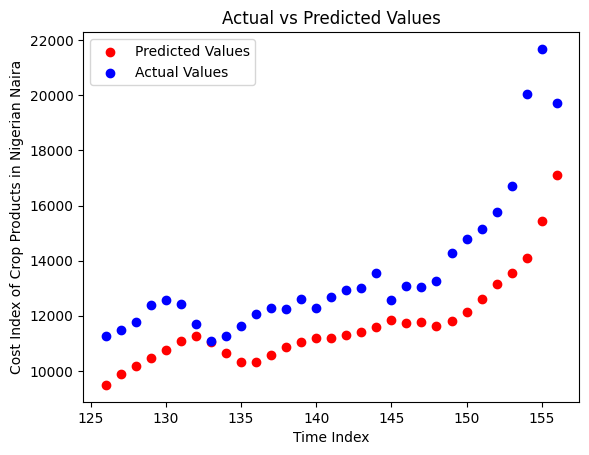

In [36]:
# Plot the prediction result
dates = df.index[-len(y_test):] 
plt.scatter(dates, y_pred, color='red', label='Predicted Values')
plt.scatter(dates, y_test, color='blue', label='Actual Values') 
plt.xlabel('Time Index')
plt.ylabel('Cost Index of Crop Products in Nigerian Naira')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## Comparison of the Linear Regression and Transformer Results

In [37]:
# Compare the results of the linear regression model and the transformer model
print(f"Linear Regression R-squared: {r_squared_lin_reg}")
print(f"Transformer R-squared: {r_squared_transformer}")
print()
print(f"Linear Regression Mean Squared Error: {mse_lin_reg}")
print(f"Transformer Mean Squared Error: {mse_transformer}")
print()
print(f"Linear Regression Mean Absolute Error: {mae_lin_reg}")
print(f"Transformer Mean Absolute Error: {mae_transformer}")

Linear Regression R-squared: 0.870835295514963
Transformer R-squared: 0.21500778311444124

Linear Regression Mean Squared Error: 3543976.8358316636
Transformer Mean Squared Error: 5364851.72855193

Linear Regression Mean Absolute Error: 1145.89095754008
Transformer Mean Absolute Error: 1930.6911219758058


## Transformer Hyperparameter Experiments